In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python3 --version

Python 3.7.12


**Import libraries**

In [23]:
!pip install pytorch-pretrained-bert==0.6.1 pytorch-nlp

!pip install sentence-transformers

!pip install keras

!pip install awscli --ignore-installed six

!pip install spacy ftfy==4.4.3
!python -m spacy download en

     |████████████████████████████████| 114 kB 5.1 MB/s 
  Attempting uninstall: pytorch-pretrained-bert
    Found existing installation: pytorch-pretrained-bert 0.6.2
    Uninstalling pytorch-pretrained-bert-0.6.2:
      Successfully uninstalled pytorch-pretrained-bert-0.6.2


  Using cached awscli-1.22.20-py3-none-any.whl (3.8 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached botocore-1.23.20-py3-none-any.whl (8.4 MB)
  Using cached PyYAML-5.4.1-cp37-cp37m-manylinux1_x86_64.whl (636 kB)
  Using cached rsa-4.7.2-py3-none-any.whl (34 kB)
  Using cached docutils-0.15.2-py3-none-any.whl (547 kB)
  Using cached s3transfer-0.5.0-py3-none-any.whl (79 kB)
  Using cached colorama-0.4.3-py2.py3-none-any.whl (15 kB)
  Using cached urllib3-1.26.7-py2.py3-none-any.whl (138 kB)
  Using cached jmespath-0.10.0-py2.py3-none-any.whl (24 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
go

  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.7
    Uninstalling urllib3-1.26.7:
      Successfully uninstalled urllib3-1.26.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
awscli 1.22.20 requires docutils<0.16,>=0.10, but you have docutils 0.17.1 which is incompatible.
awscli 1.22.20 requires PyYAML<5.5,>=3.10, but you have pyyaml 6.0 which is incompatible.
awscli 1.22.20 requires rsa<4.8,>=3.1.2, but you have rsa 4.8 which is incompatible.


     |████████████████████████████████| 12.0 MB 4.8 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
import tensorflow as tf
import pickle, os
import math
import matplotlib.pyplot as plt

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertConfig, OpenAIGPTModel, OpenAIGPTTokenizer
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification

import keras
from keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.layers import Input, Embedding, Activation, Flatten, Dense, concatenate
from keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

from sentence_transformers import SentenceTransformer

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from transformers import (
   AutoConfig,
   AutoTokenizer,
   AutoModel,
   TFAutoModelForSequenceClassification,
   AdamW,
   glue_convert_examples_to_features
)

Found GPU at: /device:GPU:0


**Import data**

In [5]:
data_dir = "https://raw.githubusercontent.com/CornellDataScience/ProjectX-2021/main/tweet-sentiment-classifier/data/miscov19.csv?token=AOSJ3S5YHZ5SPIPGPGDKVYDBVKFY4"
df = pd.read_csv(data_dir)
df.head()

,status_id,status_created_at,annotation1,annotation2,text
0,1237387231779840000,Tue Mar 10 14:38:00 +0000 2020,irrelevant,NaN,"PAGS PARODY! Plus, Joe talks coronavirus and h..."
1,1240175235304960000,Wed Mar 18 07:16:32 +0000 2020,irrelevant,NaN,#coronavirus shows that racists have absolutel...
2,1241324844920320000,Sat Mar 21 11:24:40 +0000 2020,irrelevant,NaN,@Laura1206 @ShitChester I would expect front l...
3,1241872361743360000,Sun Mar 22 23:40:18 +0000 2020,irrelevant,NaN,@kidjim25 Why would they be buying bleach thou...
4,1243024442621440000,Thu Mar 26 03:58:16 +0000 2020,irrelevant,NaN,The coronavirus is not only affecting the way ...


In [ ]:
df['annotation1'].value_counts()

calling out or correction           1331
conspiracy                           924
politics                             512
sarcasm or satire                    476
false fact or prevention             321
true prevention                      175
true public health response          163
ambiguous or hard to classify        143
fake cure                            141
irrelevant                           131
news                                  95
panic buying                          70
commercial activity or promotion      37
fake treatment                        34
emergency                             17
false public health response           3
Name: annotation1, dtype: int64

In [6]:
training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

In [ ]:
training_data.head()

,status_id,status_created_at,annotation1,annotation2,text
665,1239919197448175617,Tue Mar 17 14:19:07 +0000 2020,conspiracy,NaN,This article is from a publication by a Chines...
3249,1273844619550351361,Fri Jun 19 05:06:38 +0000 2020,false fact or prevention,NaN,NaN
2526,1266415030892978177,Fri May 29 17:04:06 +0000 2020,calling out or correction,NaN,How I contracted and survive coronavirus and t...
549,1239241272294080512,Sun Mar 15 17:25:17 +0000 2020,ambiguous or hard to classify,ambiguous or hard to classify,@skynews I was very unwell just before Christm...
2636,1272788666134323200,Tue Jun 16 07:10:39 +0000 2020,sarcasm or satire,NaN,So I’ve been out all day but I read something ...


In [7]:
train_texts = training_data.text.values
training_data['annotation1'] = training_data['annotation1'].map({'irrelevant': 2, 'conspiracy': 1, 'true treatment': 0, 'true prevention': 0, 'fake cure': 1, 'fake treatment': 1, 'false fact or prevention': 1, 'calling out or correction': 0, 'sarcasm or satire': 2, 'true public health response': 0, 'false public health repsonse': 1, 'politics': 2, 'ambiguous or hard to classify': 2, 'commercial activity or promotion': 2, 'emergency': 0, 'news': 0, 'panic buying': 1})
train_labels = training_data.annotation1.values

print(train_labels)
print(type(train_texts))
print(train_texts)

[1. 1. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'>
['This article is from a publication by a Chinese American who grew up in Wuhan province. @PMadridShow @patrickmadrid https://t.co/8gLgKHbHVf'
 nan
 'How I contracted and survive coronavirus and the effect of garlic-lemon concortion https://t.co/wyApZRmRbk'
 ...
 'Lemons contain vitamin C, an essential nutrient for your health. However, there is no evidence that lemons or dietary supplements containing vitamin C can “boost” or “supercharge” your immune system to protect you from infections.\n#COVID19 #BasedOnScience https://t.co/t03mUWoh0n'
 'Robust and inspiring #Catalyst2030 roundtable today, thanks to all! Together we can "create the mesh app" (@jackwto), break down silos, and attract all sectors and investment to #WASH to help prevent disease through safe water and sanitation for all #publichealth #covid19 #socent https://t.co/0t57SFfb6K'
 nan]


In [8]:
val_texts = testing_data.text.values
print(testing_data['annotation1'])
testing_data['annotation1'] = testing_data['annotation1'].map({'irrelevant': 2, 'conspiracy': 1, 'true treatment': 0, 'true prevention': 0, 'fake cure': 1, 'fake treatment': 1, 'false fact or prevention': 1, 'calling out or correction': 0, 'sarcasm or satire': 2, 'true public health response': 0, 'false public health repsonse': 1, 'politics': 2, 'ambiguous or hard to classify': 2, 'commercial activity or promotion': 2, 'emergency': 0, 'news': 0, 'panic buying': 1})
val_labels = testing_data.annotation1.values

print(val_labels)

391         calling out or correction
1786                  true prevention
2599                       conspiracy
1082                       conspiracy
1613    ambiguous or hard to classify
                    ...              
2756        calling out or correction
3604                       conspiracy
2338      true public health response
2124                       conspiracy
2872                sarcasm or satire
Name: annotation1, Length: 915, dtype: object
[0 0 1 1 2 2 0 0 0 0 1 2 1 2 2 0 1 2 1 0 2 2 2 0 1 0 1 1 2 2 1 1 1 2 1 2 1
 0 0 2 0 1 1 2 0 1 0 2 2 2 0 1 0 1 0 1 0 1 0 2 2 2 1 2 2 0 2 2 1 0 0 2 1 1
 1 2 2 0 0 0 2 1 0 2 2 2 0 1 0 1 1 1 0 2 0 0 1 0 0 1 0 2 1 1 0 1 2 0 2 2 1
 0 2 2 1 1 0 2 1 1 1 1 0 0 2 2 2 0 2 0 1 0 2 1 1 0 1 0 0 0 1 2 0 2 1 0 0 2
 0 2 0 2 1 1 0 0 0 0 2 1 0 1 1 0 1 2 1 0 0 0 0 2 1 1 0 1 1 2 0 0 0 1 1 0 2
 0 0 1 1 1 1 0 2 0 0 1 0 1 0 1 2 0 2 2 2 1 1 1 1 0 2 0 2 1 0 0 2 1 0 1 1 0
 0 2 0 2 0 1 2 2 1 2 2 2 1 1 1 1 1 1 2 2 2 2 1 1 0 0 1 0 0 0 0 0 0 0 0 1 2
 0 1 1 0 0 

**BERT classifier**

In [9]:
train_sentences = ["[CLS] " + str(text) + " [SEP]" for text in train_texts]
val_sentences = ["[CLS] " + str(text) + " [SEP]" for text in val_texts]

In [10]:
tokenizer = AutoTokenizer.from_pretrained('digitalepidemiologylab/covid-twitter-bert', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(text) for text in train_sentences]

print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'this', 'article', 'is', 'from', 'a', 'publication', 'by', 'a', 'chinese', 'american', 'who', 'grew', 'up', 'in', 'wu', '##han', 'province', '.', '@', 'pm', '##ad', '##rid', '##sho', '##w', '@', 'patrick', '##mad', '##rid', 'https', ':', '/', '/', 't', '.', 'co', '/', '8', '##gl', '##g', '##kh', '##bh', '##v', '##f', '[SEP]']


43.877015578026786


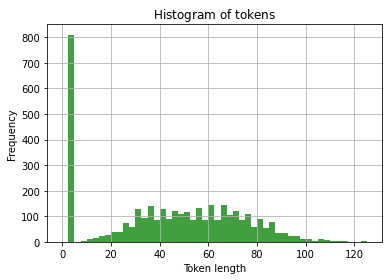

In [ ]:
# histogram

N_points = len(tokenized_texts)
x = np.zeros(1)
for i in range(N_points):
  x = np.append(x, len(tokenized_texts[i]))

n, bins, patches = plt.hist(x, 50, facecolor='green', alpha=0.75)
mean = np.mean(x, dtype=np.float64)
print(mean)

plt.xlabel('Token length')
plt.ylabel('Frequency')
plt.title(r'$\mathrm{Histogram\ of\ tokens}$')
plt.grid(True)

plt.show()

In [11]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=90, dtype="long", truncating="post", padding="post")
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [12]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, train_labels, 
                                                            random_state=42, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=42, test_size=0.2)

print(type(train_inputs))

<class 'numpy.ndarray'>


In [13]:
train_inputs = torch.tensor(train_inputs, dtype = torch.long)
validation_inputs = torch.tensor(validation_inputs, dtype = torch.long)
train_labels = torch.tensor(train_labels, dtype = torch.long)
validation_labels = torch.tensor(validation_labels, dtype = torch.long)
train_masks = torch.tensor(train_masks, dtype = torch.long)
validation_masks = torch.tensor(validation_masks, dtype = torch.long)

In [14]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
training_batch_size = 32
eval_batch_size = 8 
# REDUCING BATCH SIZE TO SAVE MEMORY

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=training_batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=eval_batch_size)


In [15]:
torch.cuda.empty_cache()

In [28]:
model = BertForSequenceClassification.from_pretrained("digitalepidemiologylab/covid-twitter-bert", num_labels=3)
model.cuda()

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

ResourceExhaustedError: ignored

In [17]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [18]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [19]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
  

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
tokenized_texts_val = [tokenizer.tokenize(text) for text in val_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_val]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=90, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(val_labels)
  
batch_size = 8

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
print('accuracy-score: %f' % (accuracy_score(flat_predictions, flat_true_labels)*100))

accuracy-score: 68.743169


In [ ]:
output_dir = '/content/drive/My Drive/CDS/ProjectX/Subprojects/bert_model.bin'
torch.save(model, output_dir)

FileNotFoundError: ignored

In [ ]:
def map(prediction):
  return {2: 'irrelevant', 1: 'conspiracy', 0: 'true treatment', 0: 'true prevention', 1: 'fake cure', 1: 'fake treatment', 1: 'false fact or prevention', 0: 'calling out or correction', 2: 'sarcasm or satire', 0: 'true public health response', 1: 'false public health repsonse', 2: 'politics', 2: 'ambiguous or hard to classify', 2: 'commercial activity or promotion', 0: 'emergency', 0: 'news', 1: 'panic buying'}[prediction]

In [ ]:
# print("Predictions: " + str(flat_predictions))
# print("True labels: " + str(flat_true_labels))

for i, text in enumerate(val_texts):
  if flat_predictions[i]!=flat_true_labels[i]:
    print("Predicted label: " + map(flat_predictions[i]))
    print("True label: " + map(flat_true_labels[i]))
    print(text)

Predicted label: commercial activity or promotion
True label: news
@Xemmypoo i don't wanna share something calling the novel coronavirus a bioweapon https://t.co/r6w5nST3B1
Predicted label: commercial activity or promotion
True label: panic buying
People 5G is OUR endgame, PLEASE, I BEG YOU, nothing else matters, covid, protests, Killing each other for their bennifet!  If? you refuse to believe truth?  You are what they wish, thoughtlessness, controlled!
https://t.co/ZeLijtHQun
Predicted label: panic buying
True label: commercial activity or promotion
@amitjha086 @Upasika1 How did china cure all its patients without any medicine for covid?
Predicted label: news
True label: commercial activity or promotion
Feels fucking weird to be the only one wearing a mask when I go out.

Did Covid pack and go home?

Or did everyone agree it's a conspiracy?
Predicted label: panic buying
True label: commercial activity or promotion
nan
Predicted label: panic buying
True label: commercial activity or p

**Sentence embeddings**

In [ ]:
model = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

sentence_embeddings = model.encode(train_texts)
with open('/content/drive/My Drive/CDS/ProjectX/Subprojects/sentence_embeddings_train.pickle', 'wb') as f:
  pickle.dump(sentence_embeddings, f)
sentence_embeddings = model.encode(val_texts)
with open('/content/drive/My Drive/CDS/ProjectX/Subprojects/sentence_embeddings_val.pickle', 'wb') as f:
  pickle.dump(sentence_embeddings, f)

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

TypeError: ignored

**Feedforward classifier**

In [ ]:
with open('/content/drive/My Drive/CDS/ProjectX/Subprojects/sentence_embeddings_train.pickle', 'rb') as f:
  sentence_embeddings_train = pickle.load(f)

with open('/content/drive/My Drive/CDS/ProjectX/Subprojects/sentence_embeddings_val.pickle', 'rb') as f:
  sentence_embeddings_val = pickle.load(f)

FileNotFoundError: ignored

In [ ]:
border = math.ceil(0.8 * sentence_embeddings_train.shape[0])

x_train, x_val = sentence_embeddings_train[:border], sentence_embeddings_train[border:]
y_train, y_val = train_labels[:border], train_labels[border:]

NameError: ignored

In [ ]:
inputs=Input(shape=(1024,), name='input')
x=Dense(1024, activation='tanh', name='fully_connected_1024_tanh')(inputs)
predictions=Dense(2, activation='softmax', name='output_softmax')(x)
model=Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Optimize using GridSearch, Bayesion Optimization, Population Based Training


In [ ]:
#Population Based Training



https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb

using logistic regression to classify persuasiveness after BERT layers